# PIK3CA: Effects of Hotspot Mutation on IRS1

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

### Import CPTAC

In [2]:
import CPTAC

Loading CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter CPTAC.embargo() to open the webpage for more details.


In [3]:
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

In [4]:
protein = 'IRS1'
gene = 'PIK3CA'

## Extract the data for hotspot mutations only 

In [5]:
#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']

In [6]:
p10_mutations = CPTAC.compare_mutations(proteomics, protein, gene)
#print(p10_mutations)
p10_mutations['Within_Hotspot'] = False
p10_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True
p10_mutations.loc[p10_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
p10_mutations = p10_mutations.loc[p10_mutations['Patient_Type'] == 'Tumor'].dropna(axis=0)
print(len(p10_mutations.loc[(p10_mutations['Within_Hotspot'] == True)]))

19


## Hotspot mutation vs non-hotspot mutation

In [7]:
in_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
out_hotspot = p10_mutations.loc[p10_mutations['Within_Hotspot'] == False]
ttest = scipy.stats.ttest_ind(in_hotspot[protein], out_hotspot[protein])
print(ttest)

Ttest_indResult(statistic=-0.1811143291128672, pvalue=0.8570734994915308)


## Hotspot mutation vs other mutations and wildtype

In [8]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] != True]
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.6714134122839353, pvalue=0.5035367810301701)


## All mutations vs wildtype

In [9]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] != 'Wildtype']
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-1.03423533120962, pvalue=0.3035716066390899)


## Hotspot mutation v wildtype

In [10]:
mutated = p10_mutations.loc[p10_mutations['Within_Hotspot'] == True]
wt = p10_mutations.loc[p10_mutations['Within_Hotspot'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
print(ttest)

Ttest_indResult(statistic=-0.890843404844897, pvalue=0.3761090199360049)


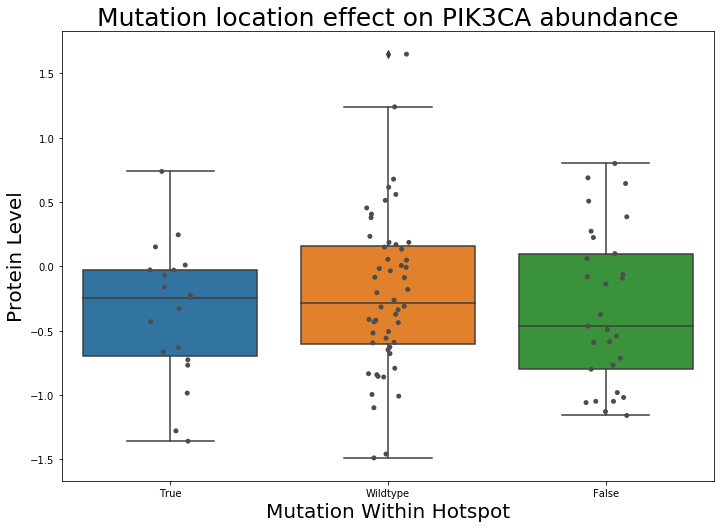

In [11]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p10_mutations, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_title('Mutation location effect on PIK3CA abundance', fontsize='25')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
plt.show()

# Phosphoproteomic Abundance

In [12]:
phos_mutations = CPTAC.compare_mutations(phos, protein, gene)
phos_mutations['Within_Hotspot'] = False
phos_mutations.loc[hotspot_patients, 'Within_Hotspot'] = True

phos_mutations.loc[phos_mutations['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
#print(phos_mutations)


phos_mutations = phos_mutations.loc[phos_mutations['Patient_Type'] == 'Tumor']
#phos_mutations = phos_mutations.dropna(axis = 0)
#print(phos_mutations)
phos_sites = list(phos_mutations)
phos_sites = phos_sites[:(len(phos_sites) - 3)]

In [13]:
sitedf = CPTAC.compare_mutations(phos, 'IRS1-S1101', gene)
print(sitedf)

      IRS1-S1101           Mutation Patient_Type
S001     -0.2040  Missense_Mutation        Tumor
S002     -0.5840           Wildtype        Tumor
S003      0.4380  Missense_Mutation        Tumor
S004     -0.2660           Wildtype        Tumor
S005     -0.4640           Wildtype        Tumor
S006     -0.9885           Wildtype        Tumor
S007      0.8265           Wildtype        Tumor
S008     -0.3005           Wildtype        Tumor
S009     -0.2190  Missense_Mutation        Tumor
S010      0.1505  Missense_Mutation        Tumor
S011     -0.1270           Wildtype        Tumor
S012     -1.4150  Missense_Mutation        Tumor
S013     -0.9170           Wildtype        Tumor
S014     -1.0545  Missense_Mutation        Tumor
S015      0.1050           Wildtype        Tumor
S016     -0.2530           Wildtype        Tumor
S017     -1.6345           Wildtype        Tumor
S018      0.6350  Missense_Mutation        Tumor
S019      1.5825           Wildtype        Tumor
S020      0.6280    

## Hotspot mutation vs non-hotspot mutation

In [14]:
p_values = []
site_names = []

pattern = re.compile(protein)
isInList = filter(pattern.search, phos_sites)

for site in phos_sites:
    #mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    mutated_list = CPTAC.compare_mutations(phos, site, gene)

    if (site is not 'Mutation'):
        sitedf = CPTAC.compare_mutations(phos, site, gene)
        sitedf['Within_Hotspot'] = False
        sitedf.loc[hotspot_patients, 'Within_Hotspot'] = True

        sitedf.loc[sitedf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        #print(phos_mutations)
        sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor']
        #print(sitedf)
        
        mutateddf = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype' ].dropna(axis=0)
        print(wtdf)
        wtdf = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype'].dropna(axis=0)
        ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
        p_values.append(ttest[1])
        site_names.append(site) 
    
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

NameError: name 'wtdf' is not defined

In [86]:
p_values = []
site_names = []

for site in phos_sites:
    #mutated = phos_mutations.loc[phos_mutations['Within_Hotspot'] == True]
    #mutated_list = CPTAC.compare_mutations(phos, site, gene)

    if (site is not 'Mutation'):
        sitedf = CPTAC.compare_mutations(phos, site, gene)
        
        sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor']
        #print(sitedf)
        sitedf['Within_Hotspot'] = False
        sitedf.loc[hotspot_patients, 'Within_Hotspot'] = True

        sitedf.loc[sitedf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        #print(sitedf)
        #print(phos_mutations)
        
        
        mutateddf = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype' ].dropna(axis=0)
        #print(mutateddf)
        wtdf = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype'].dropna(axis=0)
        
        #print(mutateddf)
        ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
        #print(site, " ", ttest)
        p_values.append(ttest[1])
        site_names.append(site) 
    
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

IRS1-S1005   Ttest_indResult(statistic=-0.2775436626978782, pvalue=0.7819473288725783)
IRS1-S1078   Ttest_indResult(statistic=1.0402525072811324, pvalue=0.30515890768146076)
IRS1-S1100   Ttest_indResult(statistic=-1.8406518465404431, pvalue=0.0691212778717038)
IRS1-S1101   Ttest_indResult(statistic=-1.8574747087121355, pvalue=0.06666618446177655)
IRS1-S1131   Ttest_indResult(statistic=-0.3035930834793605, pvalue=0.7736649329685882)
IRS1-S1132   Ttest_indResult(statistic=-1.7990835357405455, pvalue=0.09718424316781692)
IRS1-S1133   Ttest_indResult(statistic=-1.4880127005860135, pvalue=0.14545548822799928)
IRS1-S1134   Ttest_indResult(statistic=-2.3996985992555153, pvalue=0.01842380971388048)
IRS1-S1135   Ttest_indResult(statistic=0.012921691776873948, pvalue=0.990309068267633)
IRS1-S1143   Ttest_indResult(statistic=-0.5740007444587654, pvalue=0.5775155820495779)
IRS1-S1145   Ttest_indResult(statistic=-0.5740007444587654, pvalue=0.5775155820495779)
IRS1-S1222   Ttest_indResult(statistic=

## Hotspot mutation vs other mutations and wildtype

In [59]:
sites = phos.columns
p_values = []
site_names = []
phosProtList = ['IRS1']

alpha = 0.05
p_value = alpha/len(phosProtList)


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

['IRS1-S1005' 'IRS1-S1100' 'IRS1-S1101' 'IRS1-S1133' 'IRS1-S1134'
 'IRS1-S270' 'IRS1-S307' 'IRS1-S323' 'IRS1-S330' 'IRS1-S337' 'IRS1-S341'
 'IRS1-S374' 'IRS1-S415' 'IRS1-S527' 'IRS1-S531' 'IRS1-S629' 'IRS1-S636'
 'IRS1-S672' 'IRS1-S766' 'IRS1-T305' 'IRS1-T309' 'IRS1-T530']
[0.0094718  0.00020188 0.000523   0.01426172 0.0011596  0.00118185
 0.0481304  0.01005825 0.0094718  0.02559819 0.0481304  0.00118185
 0.00290455 0.01092095 0.00195889 0.00091668 0.00248824 0.0094718
 0.00248824 0.00248824 0.0094718  0.02461594]
{'IRS1-S1005': 0.0094717950390731, 'IRS1-S1100': 0.0002018777834901376, 'IRS1-S1101': 0.0005229979400382523, 'IRS1-S1133': 0.014261718949464484, 'IRS1-S1134': 0.0011595956105361492, 'IRS1-S270': 0.0011818527960791446, 'IRS1-S307': 0.04813039926788787, 'IRS1-S323': 0.010058250340791101, 'IRS1-S330': 0.0094717950390731, 'IRS1-S337': 0.02559819374662789, 'IRS1-S341': 0.04813039926788787, 'IRS1-S374': 0.0011818527960791446, 'IRS1-S415': 0.002904550128402398, 'IRS1-S527': 0.010920

## All mutations vs wildtype

In [23]:
sites = phos.columns
p_values = []
site_names = []
phosProtList = ['IRS1']

alpha = 0.05
p_value = alpha/len(phosProtList)


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                
                ### THESE LINES OF CODE CHANGE THE RESULTS!!! 
                sitedf['Within_Hotspot'] = False
                sitedf.loc[hotspot_patients, 'Within_Hotspot'] = True
                sitedf.loc[sitedf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].dropna(axis=0)
               
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}


In [21]:

print(wtdf)
print(len(wtdf))



      IRS1-Y750  Mutation Patient_Type Within_Hotspot
S008      0.000  Wildtype        Tumor       Wildtype
S035      0.437  Wildtype        Tumor       Wildtype
S058     -0.499  Wildtype        Tumor       Wildtype
3


## Hotspot mutation v wildtype

In [61]:
p_values = []
site_names = []


for site in phos_sites:   
    if (site is not 'Mutation'):
        sitedf = CPTAC.compare_mutations(phos, site, gene)
        sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor']
        sitedf['Within_Hotspot'] = False
        sitedf.loc[hotspot_patients, 'Within_Hotspot'] = True
        sitedf.loc[sitedf['Mutation'] == 'Wildtype', 'Within_Hotspot'] = 'Wildtype'
        mutateddf = sitedf.loc[sitedf['Within_Hotspot'] == True].dropna(axis=0)
        wtdf = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype'].dropna(axis=0)
        ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
        p_values.append(ttest[1])
        site_names.append(site)
    
    
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

[]
[]
{}
